<h1 style="font-size: 36px;">Amazon Review Polarity</h1>

<h2 style="font-size: 30px;">Description</h2>

<p style="font-size: 20px;">The dataset is structured as follows:</p>
<ul style="font-size: 20px;">
  <li><strong>polarity</strong>: Class index (1 for negative, 2 for positive).</li>
  <li><strong>title</strong>: Review heading.</li>
  <li><strong>text</strong>: Review body.</li>
</ul>

<p style="font-size: 20px;">The dataset is available in two CSV files: <strong>train.csv</strong> (for training) and <strong>test.csv</strong> (for testing). Each file contains the columns: <code>polarity</code>, <code>title</code>, and <code>text</code>.</p>

<hr style="border: 1px solid #000;">


---

<h1 style="font-size: 36px;">1. Importing Libraries and Dataset Setup:</h1>


In [1]:
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [2]:

# Load the training and test datasets
train_df = pd.read_csv('/kaggle/input/amazon-reviews/train.csv', names=["polarity", "title", "text"])
test_df = pd.read_csv('/kaggle/input/amazon-reviews/test.csv', names=["polarity", "title", "text"])


---

<h1 style="font-size: 36px;">2. Exploratory Data Analysis</h1>


In [3]:
train_df.shape

(3600000, 3)

In [4]:
test_df.shape

(400000, 3)

In [5]:
# Check for missing values in both datasets
print("\nMissing Values in Training Data:")
print(train_df.isnull().sum())

print("\nMissing Values in Test Data:")
print(test_df.isnull().sum())


Missing Values in Training Data:
polarity      0
title       207
text          0
dtype: int64

Missing Values in Test Data:
polarity     0
title       24
text         0
dtype: int64


In [6]:
# Check the number of unique entries in the train and test datasets based on the combination of 'title' and 'text'
train_unique = train_df.drop_duplicates(subset=["title", "text"]).shape[0]
test_unique = test_df.drop_duplicates(subset=["title", "text"]).shape[0]

print(f"Number of unique entries in training data: {train_unique}")
print(f"Number of unique entries in testing data: {test_unique}")


Number of unique entries in training data: 3600000
Number of unique entries in testing data: 400000


In [7]:
# Check data types
print("\nData Types in Training Data:")
print(train_df.dtypes)


Data Types in Training Data:
polarity     int64
title       object
text        object
dtype: object


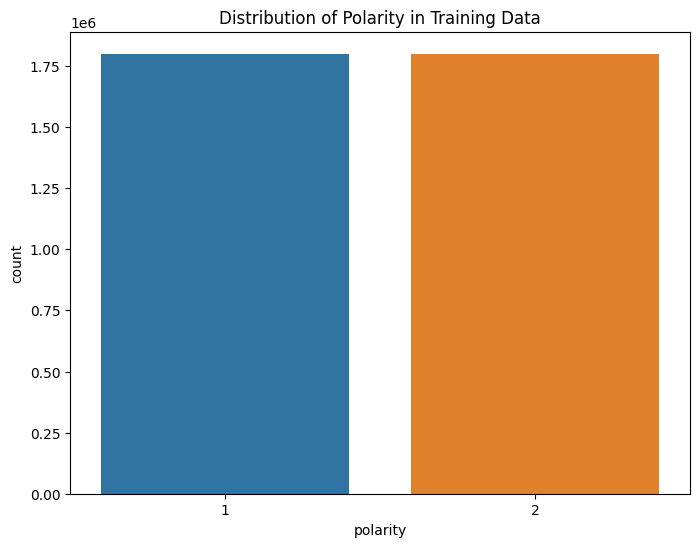

In [8]:
# Check the distribution of the target variable ('polarity')
plt.figure(figsize=(8, 6))
sns.countplot(x='polarity', data=train_df)
plt.title('Distribution of Polarity in Training Data')
plt.show()

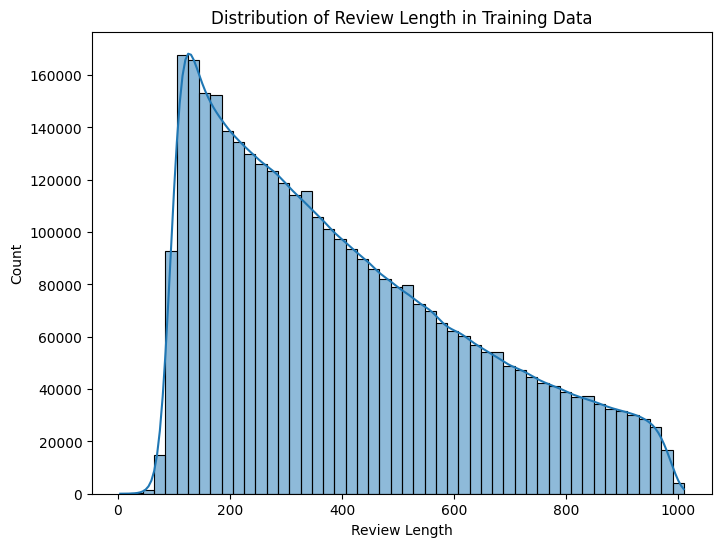

In [9]:
# Check the length of reviews in the text column
train_df['text_length'] = train_df['text'].apply(len)

plt.figure(figsize=(8, 6))
sns.histplot(train_df['text_length'], bins=50, kde=True)
plt.title('Distribution of Review Length in Training Data')
plt.xlabel('Review Length')
plt.show()

---

<h1 style="font-size: 36px;">3. Preprocessing data:</h1>


In [10]:
import nltk

# Download the required corpora
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Preload stopwords and lemmatizer
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# # I am testing with a sample of 1,000,000 rows from the training data and 400,000 rows from the test data (currently commented out)
# train_df = train_df.sample(n=1000000, random_state=42)
# test_df = test_df.sample(n=40000, random_state=42)
# # Reset index and drop the old index after sampling
# train_df = train_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)


In [12]:
# Combine the 'title' and 'text' columns and fill missing values with an empty string
train_df['text'] = train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')
test_df['text'] = test_df['title'].fillna('') + ' ' + test_df['text'].fillna('')

# Drop the 'title' column 
train_df.drop(columns=['title'], inplace=True)
test_df.drop(columns=['title'], inplace=True)

# Map polarity labels from 1/2 to 0/1
train_df['polarity'] = train_df['polarity'].map({1: 0, 2: 1})
test_df['polarity'] = test_df['polarity'].map({1: 0, 2: 1})

In [13]:
train_df.head()

,polarity,text,text_length
0,1,Stuning even for the non-gamer This sound trac...,394
1,1,The best soundtrack ever to anything. I'm read...,470
2,1,Amazing! This soundtrack is my favorite music ...,750
3,1,Excellent Soundtrack I truly like this soundtr...,721
4,1,"Remember, Pull Your Jaw Off The Floor After He...",425


---

## N-Gram Analysis

In [14]:
positive_reviews = train_df[train_df['polarity'] == 1]['text']
negative_reviews = train_df[train_df['polarity'] == 0]['text']

#### Unigram Analysis

In [15]:
def unigram_analysis(reviews, top_k=10):
    """
    Perform Unigram Analysis on reviews.
    :param reviews: Pandas Series or list of reviews.
    :param top_k: Number of top unigrams to return.
    :return: DataFrame containing unigrams and their frequencies.
    """
    vectorizer = CountVectorizer(stop_words='english')  
    unigram_matrix = vectorizer.fit_transform(reviews)  
    
    # Sum frequencies of each unigram
    unigram_counts = unigram_matrix.sum(axis=0).A1
    unigram_features = vectorizer.get_feature_names_out()
    
    # Create a DataFrame of unigrams and their counts
    unigram_df = pd.DataFrame({'unigram': unigram_features, 'count': unigram_counts})
    unigram_df = unigram_df.sort_values(by='count', ascending=False).head(top_k)
    
    return unigram_df


In [16]:
# Perform Unigram Analysis
positive_unigrams = unigram_analysis(positive_reviews, top_k=10)
negative_unigrams = unigram_analysis(negative_reviews, top_k=10)

print("Top 10 Positive Unigrams:")
print(positive_unigrams)

print("\nTop 10 Negative Unigrams:")
print(negative_unigrams)

Top 10 Positive Unigrams:
       unigram    count
92623     book  1021734
260943   great   833491
256792    good   602341
347765    like   487449
480059    read   407250
322121    just   402319
355035    love   358365
82554     best   321344
591796    time   312032
481012  really   294921

Top 10 Negative Unigrams:
        unigram   count
87543      book  951092
310433     like  546900
289841     just  546548
233111     good  438810
169473      don  394591
527523     time  365294
348799    movie  325550
427732     read  297801
98683       buy  290428
413307  product  283105


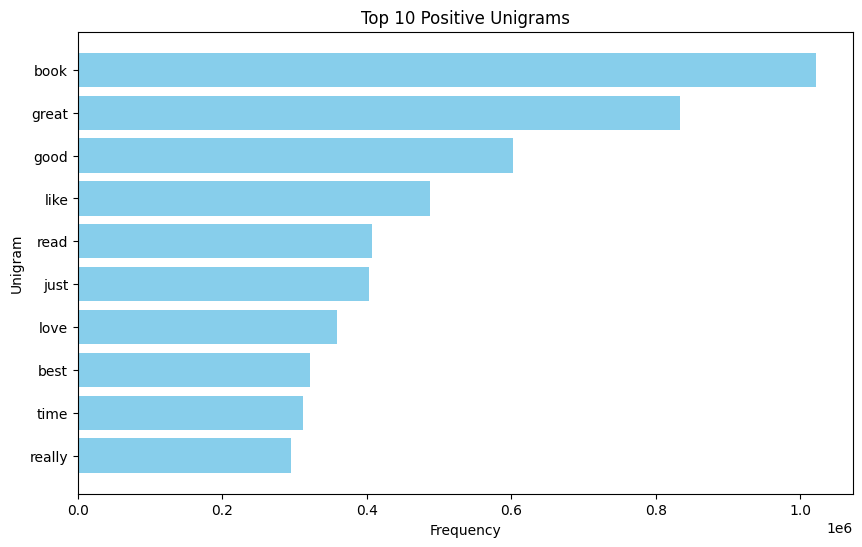

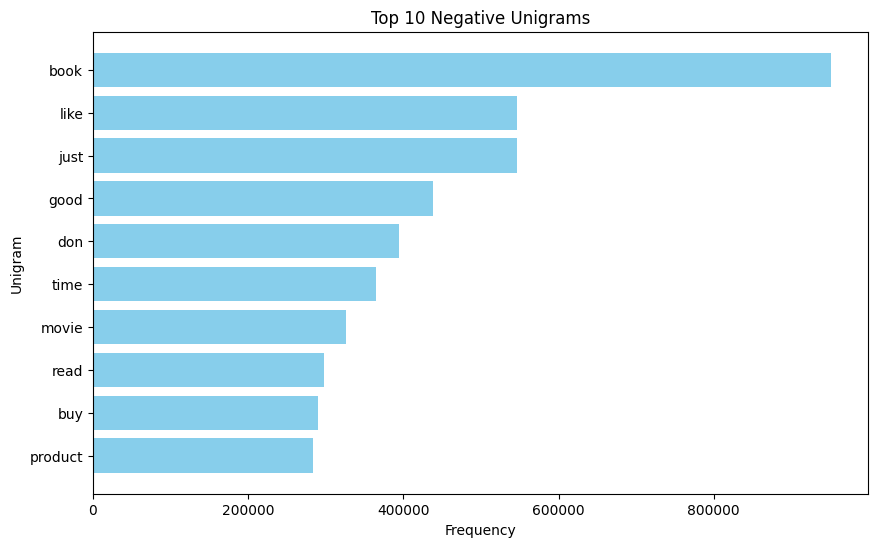

In [17]:
def plot_unigrams(unigram_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(unigram_df['unigram'], unigram_df['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Unigram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

# Plot Positive Unigrams
plot_unigrams(positive_unigrams, "Top 10 Positive Unigrams")

# Plot Negative Unigrams
plot_unigrams(negative_unigrams, "Top 10 Negative Unigrams")


#### Bigram Analysis

In [18]:
def bigram_analysis(reviews, top_k=10):
    """
    Perform Bigram Analysis on the reviews.
    :param reviews: Pandas Series or list of reviews.
    :param top_k: Number of most common bigrams to return.
    :return: DataFrame containing the bigrams and their counts.
    """
    # Create a CountVectorizer with ngram_range=(2, 2) to extract bigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english') 
    bigram_matrix = vectorizer.fit_transform(reviews)  
    
    # Calculate the frequency of the bigrams
    bigram_counts = bigram_matrix.sum(axis=0).A1
    bigram_features = vectorizer.get_feature_names_out()
    
    # Create a DataFrame with bigrams and their frequencies
    bigram_df = pd.DataFrame({'bigram': bigram_features, 'count': bigram_counts})
    bigram_df = bigram_df.sort_values(by='count', ascending=False).head(top_k)
    
    return bigram_df

In [19]:
# Perform Bigram analysis for positive and negative reviews
positive_bigrams = bigram_analysis(positive_reviews, top_k=10)
negative_bigrams = bigram_analysis(negative_reviews, top_k=10)

# Print the results
print("Top 10 Positive Bigrams:")
print(positive_bigrams)

print("\nTop 10 Negative Bigrams:")
print(negative_bigrams)


Top 10 Positive Bigrams:
                    bigram  count
13876458         read book  58734
8139122   highly recommend  52161
7524468         great book  45029
19427401          year old  41151
2054695          book read  29000
19432514         years ago  28388
7381589          good book  28349
7542350      great product  27081
19255919       works great  26911
14056247    recommend book  26086

Top 10 Negative Bigrams:
                    bigram  count
18771777       waste money  89186
18773167        waste time  55083
5159900          don waste  53014
5149928            don buy  45754
13739250         read book  38964
14844245        save money  37451
5154250           don know  35756
19412559          year old  32747
4226311   customer service  26234
5112861         doesn work  24588


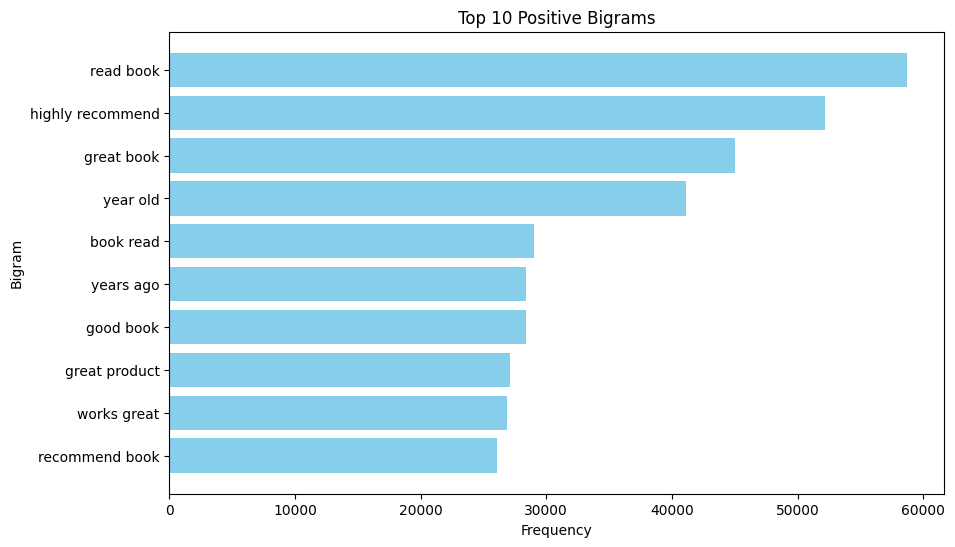

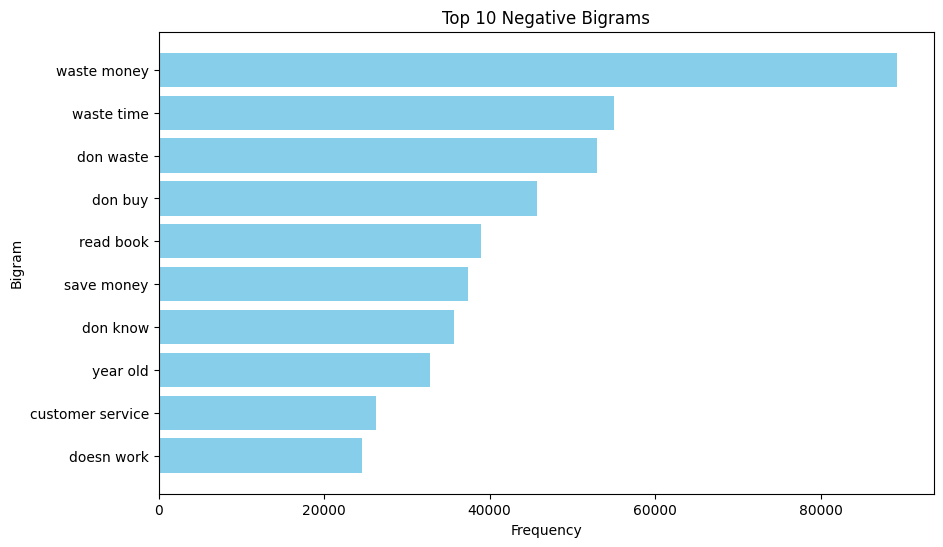

In [20]:
def plot_bigrams(bigram_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(bigram_df['bigram'], bigram_df['count'], color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Bigram')
    plt.title(title)
    plt.gca().invert_yaxis()  
    plt.show()

# Plot Positive Bigrams
plot_bigrams(positive_bigrams, "Top 10 Positive Bigrams")

# Plot Negative Bigrams
plot_bigrams(negative_bigrams, "Top 10 Negative Bigrams")


<p style="font-size: 24px;">The bigrams work better than the unigrams, because we can actually see some phrases that really describe what a good sentiment is. Although, in some parts we can still see book objects as the top words, which make us believe that our interpretation about the most selling items are related to book.</p>


---

#### Text preprocessing

In [21]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^A-Za-zÀ-ú ]+', '', text)
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in STOPWORDS]
    return tokens
train_df['tokens'] = train_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)

In [22]:
# Vocabulary building function
def build_vocab(tokenized_texts, max_vocab_size=10000):
    counter = Counter([token for text in tokenized_texts for token in text])
    # Build vocabulary based on the most frequent words
    vocab = {word: idx + 1 for idx, (word, _) in enumerate(counter.most_common(max_vocab_size))}
    vocab['<PAD>'] = 0  
    vocab['<OOV>'] = len(vocab)
    return vocab
vocab = build_vocab(train_df['tokens'])
print(f"Vocabulary size: {len(vocab)}")

Vocabulary size: 10002


In [23]:
# Function to encode text into numerical indices
def encode_texts(tokenized_texts, vocab):
    return [[vocab.get(token, vocab['<OOV>']) for token in text] for text in tokenized_texts]

# Encode train and test data using the created vocabulary
train_encoded = encode_texts(train_df['tokens'], vocab)
test_encoded = encode_texts(test_df['tokens'], vocab)

---

<h1 style="font-size: 36px;">4. Data Splitting:</h1>


In [ ]:
# Padding the sequences
def pad_sequences(sequences, max_length, padding_value=0):
    padded_sequences = np.full((len(sequences), max_length), fill_value=padding_value, dtype=int)
    for i, seq in enumerate(sequences):
        padded_sequences[i, :min(len(seq), max_length)] = seq[:max_length]
    return padded_sequences

max_length = 100  
X_train_padded = pad_sequences(train_encoded, max_length)
X_test_padded = pad_sequences(test_encoded, max_length)

In [ ]:
# Split the training data into training and validation sets
y_train = train_df['polarity'].values
y_test = test_df['polarity'].values

X_train, X_val, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train, dtype=torch.long).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.long).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

# Create DataLoader for training and validation sets
batch_size = 32
train_data = TensorDataset(X_train_tensor, y_train_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

print(f"Train loader size: {len(train_loader)}")
print(f"Validation loader size: {len(val_loader)}")


Train loader size: 90000
Validation loader size: 22500


---

<h1 style="font-size: 36px;">5. Defining the Model:</h1>


<h4 style="font-size: 28px;">Basic LSTM Model</h4>
<p style="font-size: 20px;">The first model is a standard Long Short-Term Memory (LSTM) network designed for sentiment analysis based on text data:</p>

<ul style="font-size: 20px;">
  <li><strong>Embedding Layer</strong>:
    <ul>
      <li>Converts words (tokens) into dense vector representations (embedding vectors), capturing semantic relationships between words.</li>
      <li>Implemented using <code>nn.Embedding</code> with the size of the vocabulary (<code>vocabulary_size</code>) and the dimension of the embedding vector (<code>embedding_size</code>).</li>
    </ul>
  </li>
  
  <li><strong>LSTM Layer</strong>:
    <ul>
      <li>Extracts contextual information from the sequential data and retains long-term dependencies.</li>
      <li>Implemented using <code>nn.LSTM</code> with the input size as <code>embedding_size</code> and the hidden layer size as <code>hidden_layer_size</code>.</li>
    </ul>
  </li>
  
  <li><strong>Fully Connected Layer</strong>:
    <ul>
      <li>Transforms the final hidden state of the LSTM into class probabilities (<code>number_of_classes</code>).</li>
    </ul>
  </li>
  
  <li><strong>Dropout Layer</strong>:
    <ul>
      <li>Helps prevent overfitting by randomly dropping connections during training.</li>
    </ul>
  </li>
</ul>

<p style="font-size: 20px;"><strong>Workflow:</strong></p>
<ol style="font-size: 20px;">
  <li>The input sequence of text is tokenized into word indices (<code>input_sequences</code>).</li>
  <li>The sequence is passed through the <strong>Embedding Layer</strong> to obtain embedding vectors.</li>
  <li>These embeddings are processed by the <strong>LSTM Layer</strong> to capture sequential dependencies.</li>
  <li>The last hidden state from the LSTM is passed through the <strong>Dropout Layer</strong> and then the <strong>Fully Connected Layer</strong> for classification.</li>
</ol>

<p style="font-size: 20px;"><strong>Advantages:</strong></p>
<ul style="font-size: 20px;">
  <li>Suitable for sequential data like text.</li>
  <li>Addresses vanishing gradient issues better than traditional RNNs.</li>
</ul>

<p style="font-size: 20px;"><strong>Limitations:</strong></p>
<ul style="font-size: 20px;">
  <li>Treats all words in the sequence equally, lacking the ability to focus on key words or phrases.</li>
</ul>


In [26]:
# class Sentiment_LSTMModel(nn.Module):
#     def __init__(self, vocabulary_size, embedding_size, hidden_layer_size, number_of_classes, maximum_sequence_length):
#         super(Sentiment_LSTMModel, self).__init__()
        
#         # Embedding layer
#         self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size, padding_idx=0)
        
#         # LSTM layer
#         self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, batch_first=True)
        
#         # Fully connected layer for classification
#         self.classification_layer = nn.Linear(hidden_layer_size, number_of_classes)
        
#         # Dropout layer to reduce overfitting
#         self.dropout_layer = nn.Dropout(0.5)
    
#     def forward(self, input_sequences):
#         # Get the embeddings for the input sequences
#         embedded_input = self.embedding_layer(input_sequences)
        
#         # Pass through the LSTM layer
#         lstm_output, (hidden_state, cell_state) = self.lstm_layer(embedded_input)
        
#         # Get the output from the last hidden state of the LSTM
#         final_hidden_state = hidden_state[-1]
        
#         # Apply dropout and pass through the classification layer
#         dropped_out_hidden_state = self.dropout_layer(final_hidden_state)
#         output_classification = self.classification_layer(dropped_out_hidden_state)
        
#         return output_classification


# # Parameters
# embedding_size = 100   
# hidden_layer_size = 128  
# number_of_classes = 2    
# vocabulary_size = len(vocab)
# maximum_sequence_length = 100   

# # Initialize the model
# model = Sentiment_LSTMModel(
#     vocabulary_size = vocabulary_size,
#     embedding_size = embedding_size,
#     hidden_layer_size = hidden_layer_size,
#     number_of_classes = number_of_classes,
#     maximum_sequence_length = maximum_sequence_length
# ).to(device)

# # Check the model architecture
# print(model)

# loss_function = nn.CrossEntropyLoss()
# optimizer_function = torch.optim.Adam(model.parameters(), lr=0.001)



<h4 style="font-size: 28px;">LSTM with Attention</h4>
<p style="font-size: 20px;">The second model enhances the first by integrating an <strong>Attention Mechanism</strong>, which helps the model focus on important words or phrases in the text.</p>

<ul style="font-size: 20px;">
  <li><strong>Embedding Layer</strong>:
    <ul>
      <li>Same as in the basic LSTM model, transforms tokens into dense vectors.</li>
    </ul>
  </li>
  
  <li><strong>BiLSTM Layer</strong>:
    <ul>
      <li>A bidirectional LSTM processes the sequence in both forward and backward directions, capturing context from both sides.</li>
      <li>Outputs hidden states for both directions, doubling the hidden size.</li>
    </ul>
  </li>
  
  <li><strong>Attention Layer</strong>:
    <ul>
      <li>Calculates attention scores for each hidden state to determine their importance.</li>
      <li>The attention scores are normalized using softmax to generate attention weights.</li>
      <li>A weighted sum of the LSTM outputs creates a <strong>context vector</strong>, which summarizes the sequence while emphasizing important parts.</li>
    </ul>
  </li>
  
  <li><strong>Fully Connected Layer</strong>:
    <ul>
      <li>Uses the <strong>context vector</strong> from the attention mechanism to predict the sentiment class.</li>
    </ul>
  </li>
</ul>

<p style="font-size: 20px;"><strong>Workflow:</strong></p>
<ol style="font-size: 20px;">
  <li>Input sequences are embedded via the <strong>Embedding Layer</strong>.</li>
  <li>The embeddings are processed by the <strong>BiLSTM Layer</strong> to produce hidden states for each time step in both directions.</li>
  <li>The <strong>Attention Layer</strong> assigns importance weights to the hidden states, resulting in a <strong>context vector</strong>.</li>
  <li>The <strong>context vector</strong> is passed through the <strong>Dropout Layer</strong> and <strong>Fully Connected Layer</strong> for classification.</li>
</ol>

<p style="font-size: 20px;"><strong>Advantages:</strong></p>
<ul style="font-size: 20px;">
  <li>Attention enables the model to focus on important parts of the sequence, improving interpretability and performance.</li>
  <li>BiLSTM captures context from both directions, making it more robust for nuanced text.</li>
</ul>

<p style="font-size: 20px;"><strong>Limitations:</strong></p>
<ul style="font-size: 20px;">
  <li>Computationally more expensive due to the BiLSTM and attention mechanism.</li>
</ul>


In [ ]:
import torch.nn.functional as F

class Sentiment_LSTM_Attention_Model(nn.Module):
    def __init__(self, vocabulary_size, embedding_size, hidden_layer_size, number_of_classes, maximum_sequence_length):
        super(Sentiment_LSTM_Attention_Model, self).__init__()
        
        # Embedding layer
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size, padding_idx=0)
        
        # BiLSTM layer
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, batch_first=True, bidirectional=True)
        
        # Attention Layer
        self.attention_layer = nn.Linear(hidden_layer_size * 2, 1)  # BiLSTM outputs hidden states for both directions
        
        # Fully connected layer for classification
        self.classification_layer = nn.Linear(hidden_layer_size * 2, number_of_classes)
        
        # Dropout layer to reduce overfitting
        self.dropout_layer = nn.Dropout(0.5)
    
    def attention(self, lstm_output):
        # Apply attention mechanism
        attention_scores = self.attention_layer(lstm_output)  
        attention_weights = F.softmax(attention_scores, dim=1)  
        
        # Apply attention weights to the LSTM outputs
        context_vector = torch.sum(attention_weights * lstm_output, dim=1) 
        
        return context_vector

    def forward(self, input_sequences):
        # Get the embeddings for the input sequences
        embedded_input = self.embedding_layer(input_sequences)
        
        # Pass through the BiLSTM layer
        lstm_output, (hidden_state, cell_state) = self.lstm_layer(embedded_input)
        
        # Apply attention mechanism
        context_vector = self.attention(lstm_output)
        
        # Apply dropout and pass through the classification layer
        dropped_out_hidden_state = self.dropout_layer(context_vector)
        output_classification = self.classification_layer(dropped_out_hidden_state)
        
        return output_classification


# Parameters
embedding_size = 100   
hidden_layer_size = 128  
number_of_classes = 2    
vocabulary_size = len(vocab)
maximum_sequence_length = 100   


# Initialize the model
model = Sentiment_LSTM_Attention_Model(
    vocabulary_size = vocabulary_size,
    embedding_size = embedding_size,
    hidden_layer_size = hidden_layer_size,
    number_of_classes = number_of_classes,
    maximum_sequence_length = maximum_sequence_length
).to(device)

# Check the model architecture
print(model)

Sentiment_LSTM_Attention_Model(
  (embedding_layer): Embedding(10002, 100, padding_idx=0)
  (lstm_layer): LSTM(100, 128, batch_first=True, bidirectional=True)
  (attention_layer): Linear(in_features=256, out_features=1, bias=True)
  (classification_layer): Linear(in_features=256, out_features=2, bias=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
)


<h4 style="font-size: 28px;">Comparison of the Two Models</h4>

<table style="font-size: 20px;">
  <tr>
    <th><strong>Feature</strong></th>
    <th><strong>Basic LSTM</strong></th>
    <th><strong>LSTM with Attention</strong></th>
  </tr>
  <tr>
    <td><strong>Context Understanding</strong></td>
    <td>Processes text in one direction only</td>
    <td>Processes text in both directions</td>
  </tr>
  <tr>
    <td><strong>Focus</strong></td>
    <td>Treats all words equally</td>
    <td>Focuses on important words/phrases</td>
  </tr>
  <tr>
    <td><strong>Computational Complexity</strong></td>
    <td>Lightweight</td>
    <td>Heavier due to BiLSTM and Attention</td>
  </tr>
  <tr>
    <td><strong>Application</strong></td>
    <td>Suitable for simple data</td>
    <td>Ideal for complex data or ambiguous text</td>
  </tr>
</table>

<hr>


In [28]:
# loss function and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer_function = optim.Adam(model.parameters(), lr=0.001)

<h1 style="font-size: 36px;">6. Training Setup and Evaluation::</h1>


In [29]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_loss = float('inf')  # Store the best validation loss value
    
    # To store the results for plotting later
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  
        train_loss = 0
        correct_preds = 0
        total_preds = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Perform optimization
            optimizer.zero_grad()  
            outputs = model(inputs)  
            
            # Calculate loss and perform backward pass
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Update results
            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)
        
        train_accuracy = 100 * correct_preds / total_preds
        train_loss /= len(train_loader)
        
        # Save the results for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Evaluate on the validation set
        model.eval()
        val_loss = 0
        val_correct_preds = 0
        val_total_preds = 0
        
        with torch.no_grad():  # Disable gradient calculation during evaluation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs, 1)
                val_correct_preds += (predicted == labels).sum().item()
                val_total_preds += labels.size(0)
        
        val_accuracy = 100 * val_correct_preds / val_total_preds
        val_loss /= len(val_loader)
        
        # Save the results for plotting
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        # Print results for each epoch
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        # Save the model if the validation loss decreases
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_lstm_model.pth') 
    
    # Return the lists to plot later
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and get the metrics for plotting
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, loss_function, optimizer_function, num_epochs= 5)


Epoch 1/5, Train Loss: 0.2229, Train Accuracy: 90.98%, Val Loss: 0.1962, Val Accuracy: 92.18%
Epoch 2/5, Train Loss: 0.1925, Train Accuracy: 92.40%, Val Loss: 0.1911, Val Accuracy: 92.41%
Epoch 3/5, Train Loss: 0.1834, Train Accuracy: 92.83%, Val Loss: 0.1902, Val Accuracy: 92.45%
Epoch 4/5, Train Loss: 0.1792, Train Accuracy: 93.01%, Val Loss: 0.1900, Val Accuracy: 92.46%
Epoch 5/5, Train Loss: 0.1768, Train Accuracy: 93.10%, Val Loss: 0.1890, Val Accuracy: 92.54%


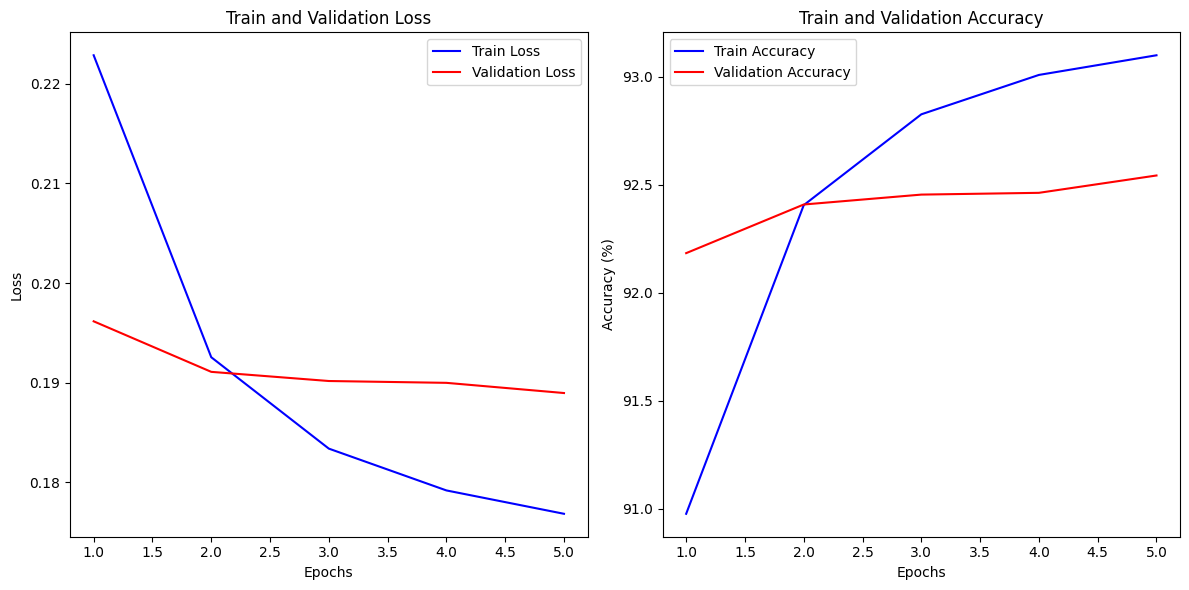

In [30]:
# Plot training and validation losses
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='blue')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


---

<h1 style="font-size: 36px;">7. Prediction and Evaluation on test data:</h1>


In [31]:
# Predict on the test set 
def predict(model, test_loader):
    model.eval()  
    predictions = []
    
    with torch.no_grad():  
        for inputs in test_loader:  
            inputs = inputs[0].to(device) 
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy()) 
    return predictions

# Convert test data into DataLoader
test_data = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long).to(device),
                           torch.tensor(y_test, dtype=torch.long).to(device)) 
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Get predictions for the test set
test_predictions = predict(model, test_loader)


Accuracy: 0.9239
Precision: 0.9204
Recall: 0.9280
F1-Score: 0.9242
Confusion Matrix:
[[183957  16043]
 [ 14402 185598]]


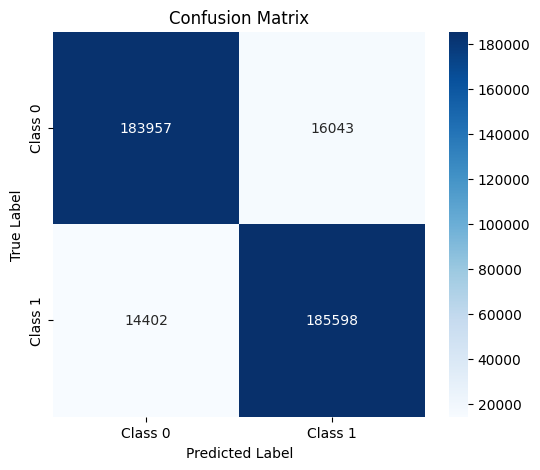

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions)
recall = recall_score(y_test, test_predictions)
f1 = f1_score(y_test, test_predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, test_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


AUC-ROC: 0.9776


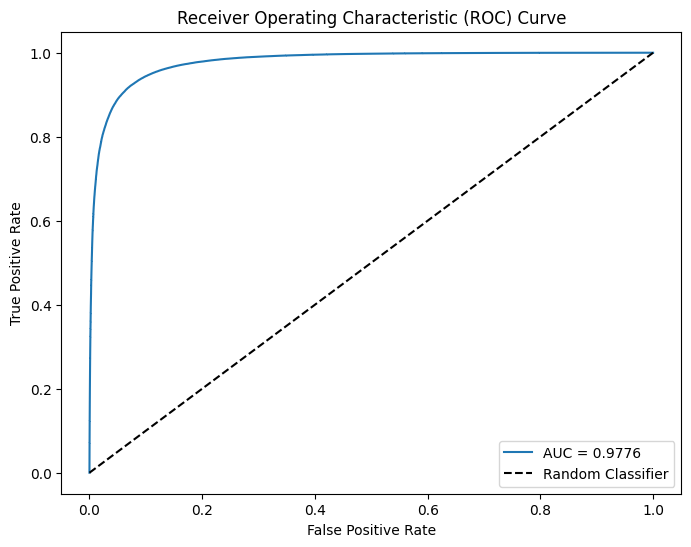

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Function to get probabilities for AUC-ROC
def predict_proba(model, test_loader):
    model.eval()  
    pred_probs = []  
    true_labels = []  
    
    with torch.no_grad():  
        for inputs, labels in test_loader:  
            inputs, labels = inputs.to(device), labels.to(device) 
            outputs = model(inputs)  
            
            # Apply softmax to get probabilities
            probs = torch.sigmoid(outputs).squeeze()  # binary classification
            pred_probs.append(probs.cpu().numpy()) 
            true_labels.append(labels.cpu().numpy()) 
    
    # Concatenate the probabilities and labels for further processing
    pred_probs = np.concatenate(pred_probs, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    
    return pred_probs, true_labels

# Function to plot the AUC-ROC curve
def plot_auc_roc(model, test_loader):
    # Get predicted probabilities and true labels
    pred_probs, true_labels = predict_proba(model, test_loader)
    
    # Calculate AUC-ROC score (for binary classification, use [:, 1] for positive class)
    auc_roc = roc_auc_score(true_labels, pred_probs[:, 1])  # For binary classification, get probabilities for class 1
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    # Plot the ROC curve
    fpr, tpr, thresholds = roc_curve(true_labels, pred_probs[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Convert test data into DataLoader
test_data = TensorDataset(torch.tensor(X_test_padded, dtype=torch.long).to(device),
                           torch.tensor(y_test, dtype=torch.long).to(device)) 
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Call the function to plot AUC-ROC
plot_auc_roc(model, test_loader)


---


<h3 style="font-size: 28px;">Model Performance</h3>

<ul style="font-size: 20px;">
  <li><strong>Accuracy</strong>: 0.9239</li>
  <li><strong>Precision</strong>: 0.9204</li>
  <li><strong>Recall</strong>: 0.9280</li>
  <li><strong>F1-Score</strong>: 0.9242</li>
  <li><strong>AUC-ROC</strong>: 0.9776</li>
</ul>

<h3 style="font-size: 28px;">Confusion Matrix</h3>

<table style="font-size: 20px;">
  <tr>
    <th><strong></strong></th>
    <th><strong>Predicted Negative</strong></th>
    <th><strong>Predicted Positive</strong></th>
  </tr>
  <tr>
    <td><strong>Actual Negative</strong></td>
    <td>183,957</td>
    <td>16,043</td>
  </tr>
  <tr>
    <td><strong>Actual Positive</strong></td>
    <td>14,402</td>
    <td>185,598</td>
  </tr>
</table>

<hr>


<h3 style="font-size: 28px;">Key Metric: <strong>AUC-ROC</strong></h3>
<p style="font-size: 20px;">
    <strong>AUC-ROC</strong> is the most important metric because:
</p>
<ul style="font-size: 20px;">
  <li>It evaluates the model's ability to distinguish between classes across all thresholds.</li>
  <li>It is independent of a specific classification threshold.</li>
  <li>It performs well in imbalanced datasets by providing a more holistic view of the model's performance.</li>
</ul>

<h3 style="font-size: 28px;">Comparison to Other Metrics:</h3>

<ul style="font-size: 20px;">
  <li><strong>Accuracy</strong>: Measures the percentage of correct predictions (both positives and negatives). It can be misleading in imbalanced datasets.</li>
  <li><strong>Precision</strong>: Measures how many of the predicted positives are actually positive. It is focused on minimizing false positives.</li>
  <li><strong>Recall</strong>: Measures how many of the actual positives were correctly identified by the model. It is focused on minimizing false negatives.</li>
  <li><strong>F1-Score</strong>: A harmonic mean of Precision and Recall, balancing the two metrics when there’s a trade-off between them.</li>
</ul>


---


# 8. Error Analysis 

In [34]:
# Identify misclassified samples
misclassified_idx = [i for i in range(len(y_test)) if y_test[i] != test_predictions[i]]

# Extract misclassified data
misclassified_texts = [test_df['text'][i] for i in misclassified_idx]
misclassified_labels = [y_test[i] for i in misclassified_idx]
misclassified_preds = [test_predictions[i] for i in misclassified_idx]

# Analyze text lengths of misclassified samples
misclassified_lengths = [len(text.split()) for text in misclassified_texts]
print(f"Average length of misclassified samples: {np.mean(misclassified_lengths):.2f}")

# Example: Investigate specific patterns in misclassified samples
print("Examples of misclassified texts:")
for i in range(5):
    print(f"Text: {misclassified_texts[i]}")
    print(f"True Label: {misclassified_labels[i]}, Predicted Label: {misclassified_preds[i]}")
    print("---")


Average length of misclassified samples: 79.29
Examples of misclassified texts:
Text: Not an "ultimate guide" Firstly,I enjoyed the format and tone of the book (how the author addressed the reader). However, I did not feel that she imparted any insider secrets that the book promised to reveal. If you are just starting to research law school, and do not know all the requirements of admission, then this book may be a tremendous help. If you have done your homework and are looking for an edge when it comes to admissions, I recommend some more topic-specific books. For example, books on how to write your personal statment, books geared specifically towards LSAT preparation (Powerscore books were the most helpful for me), and there are some websites with great advice geared towards aiding the individuals whom you are asking to write letters of recommendation. Yet, for those new to the entire affair, this book can definitely clarify the requirements for you.
True Label: 0, Predicted Label: 1

<h3 style="font-size: 28px;">Misclassification Analysis</h3>
<p style="font-size: 20px;">
    The average length of misclassified samples is <strong>79.29</strong>.
</p>

<h3 style="font-size: 28px;">Misclassified Texts and Reasons:</h3>

<ul style="font-size: 20px;">
    <li><strong>1. Text:</strong> "Not an 'ultimate guide'... clarify the requirements for you."
        <ul>
            <li><strong>True Label:</strong> 0 (Negative)</li>
            <li><strong>Predicted Label:</strong> 1 (Positive)</li>
            <li><strong>Reason:</strong> The text starts with a negative critique ("Not an 'ultimate guide'") but ends with a positive note. The model fails to properly capture the mixed sentiment and incorrectly classifies it as positive.</li>
        </ul>
    </li>
    <li><strong>2. Text:</strong> "Amazing... love it... very touch. It's too bad that in the DVD description it doesn't mention no subtitles."
        <ul>
            <li><strong>True Label:</strong> 1 (Positive)</li>
            <li><strong>Predicted Label:</strong> 0 (Negative)</li>
            <li><strong>Reason:</strong> The text includes a positive sentiment ("love it"), but the model misinterprets the negative complaint about the lack of subtitles, resulting in an incorrect negative classification.</li>
        </ul>
    </li>
    <li><strong>3. Text:</strong> "Patricia Cornwell has turned me into a reader... I highly recommend reading not just this book but the entire Kay Scarpetta series."
        <ul>
            <li><strong>True Label:</strong> 1 (Positive)</li>
            <li><strong>Predicted Label:</strong> 0 (Negative)</li>
            <li><strong>Reason:</strong> Despite the strong positive sentiment and recommendation, the model mistakenly classifies the review as negative due to focusing on certain negative aspects.</li>
        </ul>
    </li>
    <li><strong>4. Text:</strong> "Had to return it... Squeem makes a vest version too so maybe that one will be a better choice."
        <ul>
            <li><strong>True Label:</strong> 0 (Negative)</li>
            <li><strong>Predicted Label:</strong> 1 (Positive)</li>
            <li><strong>Reason:</strong> The model misinterprets the frustration with the sizing and discomfort as a positive experience because the reviewer provides a potential solution in the end.</li>
        </ul>
    </li>
    <li><strong>5. Text:</strong> "I recommend ordering a size or 2 larger than your regular size... the quality of the product is exceptionally well stitched."
        <ul>
            <li><strong>True Label:</strong> 1 (Positive)</li>
            <li><strong>Predicted Label:</strong> 0 (Negative)</li>
            <li><strong>Reason:</strong> The model misses the overall positive sentiment, especially regarding the product quality, and incorrectly focuses on the sizing issue, leading to a negative classification.</li>
        </ul>
    </li>
</ul>


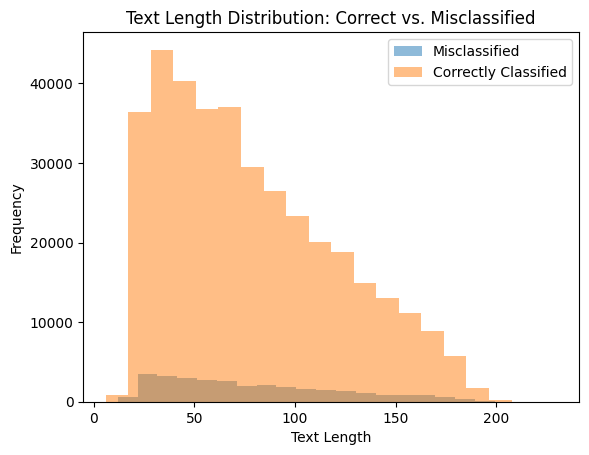

In [35]:
# Analyze text length distribution
correct_idx = [i for i in range(len(y_test)) if y_test[i] == test_predictions[i]]
correct_lengths = [len(test_df['text'][i].split()) for i in correct_idx]

plt.hist(misclassified_lengths, bins=20, alpha=0.5, label="Misclassified")
plt.hist(correct_lengths, bins=20, alpha=0.5, label="Correctly Classified")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.legend()
plt.title("Text Length Distribution: Correct vs. Misclassified")
plt.show()


<h3 style="font-size: 28px;">Error Analysis: Text Length Distribution and Misclassification</h3>

<h3 style="font-size: 28px;">1. Text Length Distribution</h3>
<ul style="font-size: 20px;">
    <li><strong>Correctly Classified Samples:</strong>
        <ul>
            <li>Majority are short texts, with a peak at the 0-50 token range.</li>
            <li>Distribution spreads across various text lengths, suggesting the model is able to classify longer texts well.</li>
        </ul>
    </li>
    <li><strong>Misclassified Samples:</strong>
        <ul>
            <li>Misclassifications are concentrated in shorter text lengths (0-50 tokens).</li>
            <li>Misclassified samples have a lower frequency than correctly classified samples in the same range.</li>
        </ul>
    </li>
</ul>

<h3 style="font-size: 28px;">2. Key Insights</h3>
<ul style="font-size: 20px;">
    <li><strong>Short Texts and Misclassification:</strong> Short texts are more likely to be misclassified. The model may struggle due to the lack of context and fewer features available in short texts.</li>
    <li><strong>Longer Texts:</strong> The model performs better on longer texts, where it can capture more context and avoid irrelevant features.</li>
</ul>


# Sources of Learning

1. [Text Preprocessing: Steps, Tools, and Examples](https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908)
2. [Amazon Instrument: Sentimental Analysis](https://www.kaggle.com/nayansakhiya/amazon-instrument-sentimental-analysis)
3. [Sentiment Analysis | Amazon reviews](https://www.kaggle.com/benroshan/sentiment-analysis-amazon-reviews#Story-Generation-and-Visualization-from-reation/)
4. [PyTorch - Bi-LSTM + Attention](https://www.kaggle.com/code/robertke94/pytorch-bi-lstm-attention)